# Technical Test Pythae

To run this notebook you will need a Python version >=3.8

## Preliminaries: Setup environnement & Data

In [1]:
#%pip install pythae torchvision torch torchsummary matplotlib

In [2]:
import torch
from torch.utils.data import Dataset
from pythae.data.datasets import DatasetOutput


class MNIST(Dataset):
    def __init__(self, data):
        self.data = data.type(torch.float)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        return DatasetOutput(data=x)


In [3]:
from torchvision import datasets

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

In [ ]:
import random

def sample_indices(vector, k, seed=None):
    # # Example usage:
    # vector = torch.tensor([0, 0, 1, 1, 2, 2, 2, 3, 3, 3, 3])  # Example tensor with 4 labels
    # k = 3  # Number of points to sample from each label
    # seed = 42  # Seed for reproducibility
    # sampled_indices = sample_indices(vector, k, seed)
    # print("Sampled indices:", sampled_indices)

    if seed is not None:
        random.seed(seed)

    indices = []
    label_dict = {}

    # Group indices by label
    for i, label in enumerate(vector):
        label = label.item() if torch.is_tensor(label) else label
        if label not in label_dict:
            label_dict[label] = [i]
        else:
            label_dict[label].append(i)

    # Sample k points from each label
    for label, label_indices in label_dict.items():
        sampled_indices = random.sample(label_indices, min(k, len(label_indices)))
        indices.extend(sampled_indices)

    random.shuffle(indices)

    return indices




In [4]:
train_dataset = MNIST(mnist_trainset.data[:200].reshape(-1, 1, 28, 28) / 255.)
eval_dataset = MNIST(mnist_trainset.data[200:].reshape(-1, 1, 28, 28) / 255.)

NameError: name 'eval_dataset' is not defined

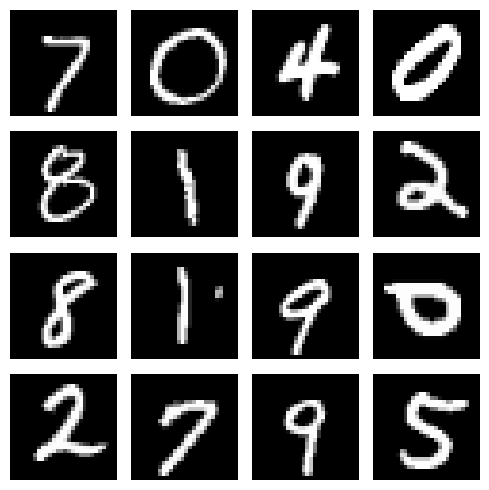

In [ ]:
import matplotlib.pyplot as plt


_, ax = plt.subplots(nrows=4, ncols=4, figsize=(5,5))

for i in range(4):
    for j in range(4):
        ax[i][j].imshow(train_dataset[i*4+j].data.movedim(0, 2), cmap='gray')
        ax[i][j].axis('off')
plt.tight_layout()

## Step 1: Training a VAE with Pythae

To train a VAE with Pythae, the first step is to define the configuration you want to apply to your
autoencoder model. This will be used to instantiate the VAE instance. Then, you will need to
setup the training configuration and launch a training.

**Objective: Complete the following code based so you can launch a training using Pythae's model.**

Required training setup:
- The model should have a latent dimension of 8
- Train the model for 50 epochs, a learning rate of 3e-3 and batch_size of 64
- Save the best model on validation set in a folder named `experiments`

In [ ]:
from pythae.models import VAEConfig, VAE


model_config = VAEConfig(
    input_dim=(1, 28, 28),
    latent_dim=8
)

model = VAE(
    model_config=model_config
)

In [ ]:
from pythae.trainers import BaseTrainerConfig, BaseTrainer


training_config = BaseTrainerConfig(
    output_dir='experiments',
    num_epochs=50,
    learning_rate=3e-3,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
)

trainer = BaseTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    training_config=training_config
)

trainer.train()

/mnt/Data/Code/test-pythae/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Model passed sanity check !
Ready for training.

Created experiments folder since did not exist.

Created experiments/VAE_training_2024-01-16_15-19-01. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 50
 - per_device_train_batch_size: 64
 - per_device_eval_batch_size: 64
 - checkpoint saving every: None
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.003
    maximize: False
    weight_decay: 0
)
Scheduler: None

Successfully launched training !

Eval of epoch 1/50: 100%|██████████| 930/930 [00:01<00:00, 686.77batch/s]
--------------------

# Step 2: Defining a custom encoder.

Pythae provides the user with the possibility to create its own encoder
and decoder networks. 

**Objective: Complete the following code to train a VAE with a custom encoder network chosen as a
Convolutional Neural Net**

In [ ]:
import torch.nn as nn
from pythae.models.nn import BaseEncoder
from pythae.models.base.base_utils import ModelOutput


class CustomEncoder(BaseEncoder):
    def __init__(self, args=None):
        BaseEncoder.__init__(self)
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=0),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=0),
            nn.AvgPool2d(kernel_size=6),
        )
        self.embedding = nn.Linear(64, 8)
        self.log_covariance = nn.Linear(64, 8)

    def forward(self, x: torch.Tensor) -> ModelOutput:
        out = self.layers(x).squeeze()
        output = ModelOutput(
            embedding=self.embedding(out),
            log_covariance=self.log_covariance(out)
        )
        return output

custom_encoder = CustomEncoder()  

In [ ]:
from torchsummary import summary
summary(custom_encoder, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 13, 13]             320
            Conv2d-2             [-1, 64, 6, 6]          18,496
         AvgPool2d-3             [-1, 64, 1, 1]               0
            Linear-4                    [-1, 8]             520
            Linear-5                    [-1, 8]             520
Total params: 19,856
Trainable params: 19,856
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.08
Estimated Total Size (MB): 0.14
----------------------------------------------------------------


In [ ]:
model_config = VAEConfig(
    input_dim=(1, 28, 28),
    latent_dim=8
)

model = VAE(
    model_config=model_config,
)

In [ ]:
training_config = BaseTrainerConfig(
    output_dir='experiments/custom',
    num_epochs=50,
    learning_rate=3e-3,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
)

trainer = BaseTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    training_config=training_config
)

trainer.train()

Model passed sanity check !
Ready for training.

Created experiments/custom folder since did not exist.

Created experiments/custom/VAE_training_2024-01-16_15-32-03. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 50
 - per_device_train_batch_size: 64
 - per_device_eval_batch_size: 64
 - checkpoint saving every: None
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.003
    maximize: False
    weight_decay: 0
)
Scheduler: None

Successfully launched training !

Eval of epoch 1/50: 100%|██████████| 930/930 [00:01<00:00, 519.70batch/s]
--------------------------------------------------------------------------
Train loss: 47.6838
Eval loss: 30.3856
--------------------------------------------------------------------------
Eval of epoch 2/50: 100%|██████████| 930/930 [00:01<00:00, 500.52batch/s]
----------

## Step 3: Generating synthetic images with PythAE

Pythae makes available several sampling methods that allow the users to generate synthetic data
directly from a trained model.

**Objective: Use one the models you have previously trained and generate synthetic images**

Required setting:
- Generate 16 images using the `NormalSampler`
- Generate 24 images using a Gaussian Mixture with 7 Gaussians

*Note: Do not expect the generation to be good given the model chosen, the number of training
samples and the training time. This exercise is meant to see how familiar you are with Pythae and
VAEs in general*

In [ ]:
from pythae.models import AutoModel

import glob

trained_model = AutoModel.load_from_folder(
    glob.glob('experiments/VAE_training_*/final_model')[0]
)

In [ ]:
from pythae.samplers import NormalSampler


sampler = NormalSampler(
    model=trained_model,
    sampler_config=None
)
gen_data = sampler.sample(
    num_samples=16,
)

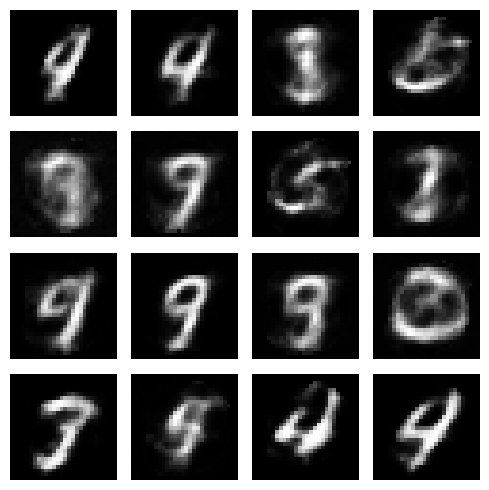

In [ ]:
import matplotlib.pyplot as plt


_, ax = plt.subplots(nrows=4, ncols=4, figsize=(5,5))

for i in range(4):
    for j in range(4):
        ax[i][j].imshow(gen_data[i*4+j].data.movedim(0, 2), cmap='gray')
        ax[i][j].axis('off')
plt.tight_layout()

In [ ]:
from pythae.samplers import RHVAESampler, RHVAESamplerConfig


rh_sampler_config = RHVAESamplerConfig(
)

rh_sampler = RHVAESampler(
    sampler_config=None,
    model=trained_model
)

rh_sampler.fit(
    train_data=train_dataset.data
)

rh_gen_data = rh_sampler.sample(
   num_samples=24
)

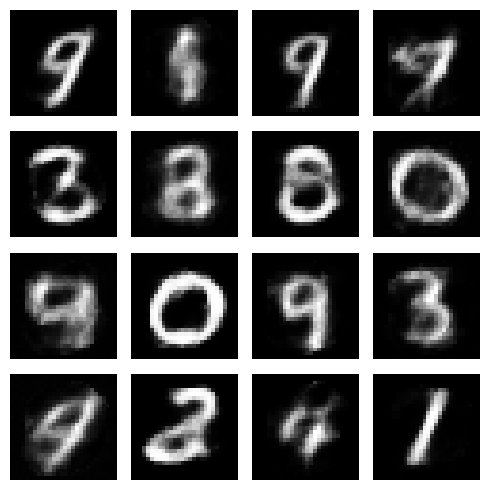

In [ ]:
import matplotlib.pyplot as plt


_, ax = plt.subplots(nrows=4, ncols=4, figsize=(5,5))

for i in range(4):
    for j in range(4):
        ax[i][j].imshow(gmm_gen_data[i*4+j].data.movedim(0, 2), cmap='gray')
        ax[i][j].axis('off')
plt.tight_layout()